In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

# TO DO's
* link the data to the db that reloads
* find the answers dataset and link as well
* make analsys of what are the best letters to start with (compared to answers)

In [3]:
tweets = pd.read_csv('/Users/amos/downloads/tweets.csv')

In [4]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

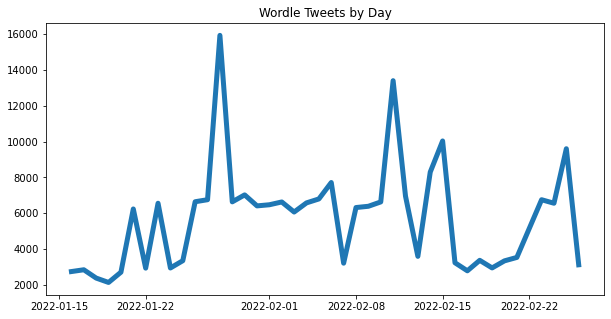

In [5]:
tweets['tweet_date'].value_counts() \
    .plot(figsize=(10, 5), title='Wordle Tweets by Day', lw=5)
plt.show()

In [6]:
tweets.groupby('wordle_id')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


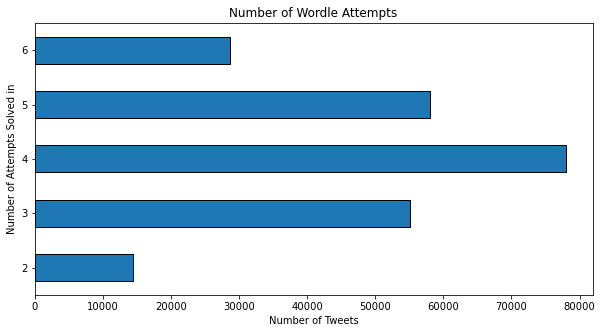

In [7]:
ax = tweets['n_attempts'].value_counts() \
    .sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

In [8]:
# Make dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [9]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

In [10]:
# Keep additional tweet text
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

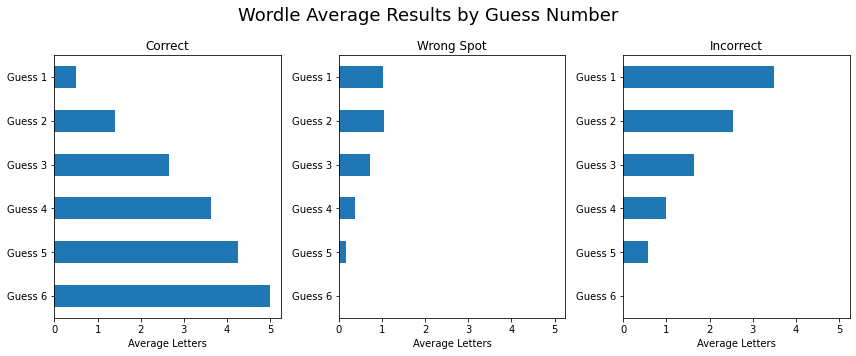

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

In [54]:
answers = pd.read_html('https://wordfinder.yourdictionary.com/wordle/answers/')
answers = pd.concat(answers).drop(columns='Date')
# answers['Wordle #'] = 'Wordle ' + answers['Wordle #'].astype(str)

answers.head(2)

,Wordle #,Answer
0,383,AGAPE
1,382,FLUFF


In [59]:
tweets1 = tweets.join(answers.set_index('Wordle #'), on='id')

In [60]:
first_guess_correct = []
for i, d in tweets1.dropna(subset=['Answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['Answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

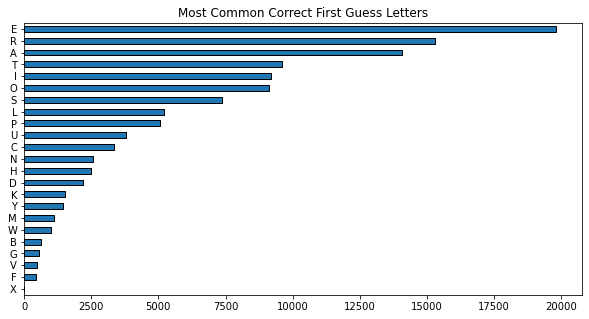

In [61]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black')
plt.show()

In [63]:
tweets1.groupby('Answer')['n_attempts'].value_counts().unstack().style \
        .background_gradient(axis=1)

n_attempts,2,3,4,5,6
Answer,,,,,
ALOFT,360,1836,2832,1974,811
AROMA,353,1791,2386,1572,733
BLOKE,476,1603,2419,1782,826
CAULK,158,740,1063,775,486
COULD,443,2100,2528,1418,457
CRIMP,170,1009,1384,730,187
CYNIC,110,726,2258,2303,1051
DODGE,97,540,1085,1062,573
ELDER,195,943,1762,2061,1492


<AxesSubplot:title={'center':'Number of Attempts'}>

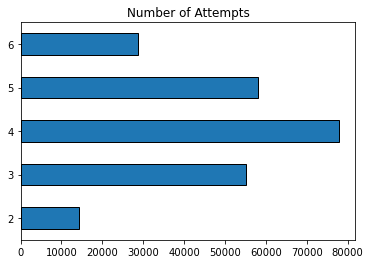

In [64]:
tweets1['n_attempts'].value_counts() \
    .sort_index().plot(kind='barh',
                       title='Number of Attempts',
                       edgecolor='black')

In [68]:
tweets1

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id,has_guess1,guess1,...,guess5_incorrect,guess5_wrong_spot,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_wrong_spot,guess6_correct,additional_text,Answer
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210,True,⬛⬛🟨🟨⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,PANIC
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210,True,⬛⬛⬛⬛⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,PANIC
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210,True,⬛⬛⬛🟨⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,PANIC
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210,True,⬛⬛🟨⬛⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,PANIC
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210,True,⬛⬛🟨⬛⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,PANIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234181,Wordle 251,1497413074709590024,2022-02-26,SammieLee14,Wordle 251 6/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n⬛⬛🟨⬛⬛\n⬛🟩⬛⬛⬛\n...,2022-02-26 03:27:52+00:00,6,251,True,⬛⬛⬛⬛⬛,...,3.0,1.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,NaN,VIVID
234182,Wordle 251,1497413096457097218,2022-02-26,real_hotaru,Wordle 251 5/6\n\n⬛⬛⬛⬛⬛\n⬛⬛⬛⬛⬛\n🟨⬛🟨⬛⬛\n⬛⬛🟨⬛⬛\n...,2022-02-26 03:27:57+00:00,5,251,True,⬛⬛⬛⬛⬛,...,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,Bruh,VIVID
234183,Wordle 251,1497413098210222084,2022-02-26,mmelmazz,Wordle 251 5/6\n\n⬛⬛⬛⬛⬛\n⬛🟩⬛⬛⬛\n🟨🟩⬛⬛⬛\n⬛🟩🟩🟩🟩\n...,2022-02-26 03:27:57+00:00,5,251,True,⬛⬛⬛⬛⬛,...,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,NaN,VIVID
234184,Wordle 251,1497413110725943298,2022-02-26,Ancient_Wonder,Wordle 251 3/6\n\n⬛⬛🟩⬛⬛\n🟩🟩⬛🟩⬛\n🟩🟩🟩🟩🟩,2022-02-26 03:28:00+00:00,3,251,True,⬛⬛🟩⬛⬛,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,VIVID


In [72]:
tweets1['day'] = tweets1['tweet_datetime'].dt.day_name()
tweets1['tweet_date_'] = tweets1['tweet_datetime'].dt.date

tweets1.groupby(['tweet_date_','day'])['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient()

,n_attempts,2,3,4,5,6
tweet_date_,day,,,,,
2022-01-16,Sunday,214,863,1027,467,159
2022-01-17,Monday,194,879,998,549,210
2022-01-18,Tuesday,191,782,807,406,179
2022-01-19,Wednesday,53,272,641,683,472
2022-01-20,Thursday,378,1000,818,369,129
2022-01-21,Friday,490,1961,2114,1216,449
2022-01-22,Saturday,225,895,1007,592,202
2022-01-23,Sunday,277,1611,2451,1595,615
2022-01-24,Monday,38,343,927,1039,583
